In [64]:
import os
from glob import glob
import gc
import sys
path = os.path.join(os.getcwd(), '..')
effdet_path = '/userhome/34/h3509807/effdet_module'
sys.path.append(path)
sys.path.append(effdet_path)

import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from ensemble_boxes import *

from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

from src.config.GlobalConfig import GlobalConfig
from src.data.df_utils import read_boxes_df, get_kfolds_df
from src.common.utils import read_image, xywh2ltrb

In [84]:
CSV_PATH = '/userhome/34/h3509807/wheat-data/train.csv'
DATA_ROOT_PATH = '/userhome/34/h3509807/wheat-data'
MODEL_DIR = '/userhome/34/h3509807/Wheat-Detection-2020/models/effdet5-512'
MODEL_CKPT = f'{MODEL_DIR}/best-checkpoint.bin'

RESIZE_SZ = 512
SCALE_FACTOR = int(1024 / RESIZE_SZ)

#### 1. Dataset and Transforms

In [48]:
boxes_df = read_boxes_df(CSV_PATH)
kfolds_df = get_kfolds_df(boxes_df, kfolds = 5)

/userhome/31/h3509807/anaconda3/envs/fastai2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [49]:
def get_valid_transforms():
    return A.Compose([
        A.Resize(height = RESIZE_SZ, width = RESIZE_SZ, p = 1.0),
        ToTensorV2(p = 1.)
        ], p = 1.)

In [50]:
x = kfolds_df[kfolds_df.fold == 0].index.values

In [51]:
class kFoldsDataset(Dataset):
    def __init__(self, boxes_df, kfolds_df, kfolds_idx, 
                 train_dir, transforms = None):
        super().__init__()
        
        self.image_ids = kfolds_df[kfolds_df.fold == kfolds_idx].index.values
        self.boxes_df = boxes_df
        self.transforms = transforms
        self.train_dir = train_dir
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image, boxes = self.load_image_and_boxes(index)
        
        # only one class
        labels = torch.ones((boxes.shape[0],), dtype = torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['index'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })

                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    #yxyx: be warning
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  
                    target['labels'] = torch.as_tensor(sample['labels'])
                    break
                    
        assert target['boxes'].shape[0] ==target['labels'].shape[0], 'boxes len != labels len'
        return image, target, image_id
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = read_image(image_id, self.train_dir)
        records = self.boxes_df[self.boxes_df['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes = xywh2ltrb(boxes)
        return image, boxes
    
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [52]:
train_dir = f'{DATA_ROOT_PATH}/train'
tfms = get_valid_transforms()

ds = kFoldsDataset(boxes_df, kfolds_df, kfolds_idx = 0, 
                   train_dir = train_dir, transforms = tfms)

In [53]:
dl = DataLoader(ds, batch_size = 2, shuffle = False, 
                num_workers = 4, drop_last = False, 
                collate_fn = collate_fn)

#### 2. Model

In [62]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size= RESIZE_SZ
    net.class_net = HeadNet(config, num_outputs = config.num_classes, 
                            norm_kwargs = dict(eps=.001, momentum = .01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

net = load_net(MODEL_CKPT)

#### 3. Predictions

In [63]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size = RESIZE_SZ, 
            iou_thr = 0.44, skip_box_thr = 0.43, weights = None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

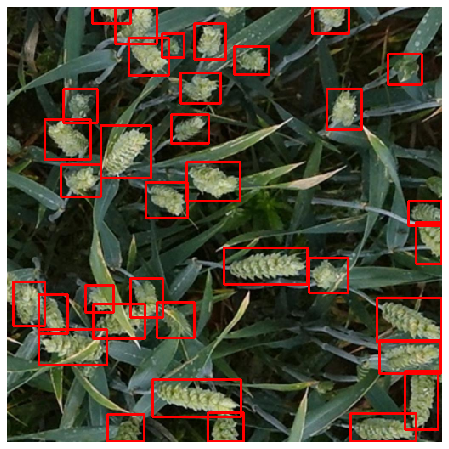

In [78]:
for j, (images, _, image_ids) in enumerate(dl):
    break

predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample);

#### 4. Submission

In [79]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [82]:
results = []

for images, _, image_ids in dl:
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes * SCALE_FACTOR).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

/userhome/31/h3509807/anaconda3/envs/fastai2/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:74: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/userhome/31/h3509807/anaconda3/envs/fastai2/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:62: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')


In [83]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,00764ad5d,0.9535 221 279 117 124 0.8918 89 264 108 95 0....
1,00e903abe,0.8731 17 384 128 208 0.8208 532 684 144 199 0...
2,0114c88aa,0.9023 586 20 121 119 0.8163 439 420 143 142 0...
3,0126b7d11,0.7387 290 868 157 94 0.7373 845 841 121 117 0...
4,01e2c61d9,0.9287 883 439 116 188 0.9078 398 848 133 120 ...


In [90]:
test_df.to_csv(f'{MODEL_DIR}/inference/kfold_0_preds.csv', index = False)